# week3_HW_강은서_6조 

# HW1. 위에 나온 Multinomial Naive Bayes Classifier 예시 해보기

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

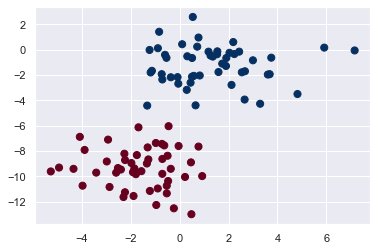

In [2]:
from sklearn.datasets import make_blobs #가우시안정규분포 이용해 가상 데이터 생성
X, y = make_blobs(100,2,centers=2,random_state=2, cluster_std=1.5) #표본데이터수=100, 독립변수 수=2, random_state;난수발생시드=2, cluster 표준편차=1.5
plt.scatter(X[:,0], X[:,1],c=y,s=50,cmap='RdBu');

[(-15, 5), (-8, 8)]

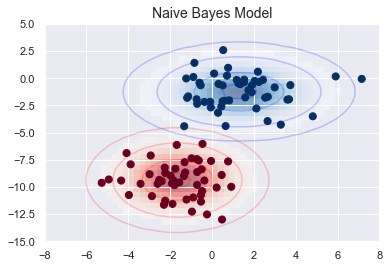

In [3]:
#Gausiian naive bayes 모델 시각화
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

여기서 타원은 타원의 중심으로 갈 수록 확률이 더 커지는 각 lable에 대한 가우스 생성모델을 나타냄 (책 참고)

In [4]:
#사후확률 계산하기
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [5]:
#새로운 데이터 만들어 label예측하기
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

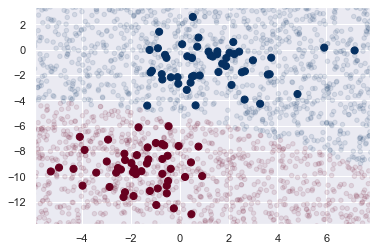

In [6]:
# Now we can plot this new data to get an idea of where the decision boundary is
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

살짝 굽은 경계가 보임

In [7]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

# HW2: 선택 1

아래 링크로 가서 와인의 특성에 따라 와인의 재배종을 분류하는 데이터를 다운
https://www.kaggle.com/brynja/wineuci

1. 데이터 전처리 및 시각화
    a. 데이터 분포를 보고
    b. 결측치 없나 확인하고
    c. feature 결정하고
2. Train-Test set split하기
3. Test에 다음의 모델을 fit해보기
    a. LDA / GDA
    b. Logistic Regression
    c. Logistic Regression with feature expansion (kcv로 차수결정)
4. 각 모델에 대해 Test MSE 보고하고 결과 해석하기

## 1.데이터 전처리 및 시각화

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#데이터 불러오기
wine = pd.read_csv('Wine.csv', header=None)
wine

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [10]:
# 열 이름 설정
wine.columns=['class'
    ,'Alcohol'
    ,'Malic_acid'
    ,'Ash'
    ,'Alcalinity_of_ash'
    ,'Magnesium'
    ,'Total_phenols'
    ,'Flavanoids'
    ,'Nonflavanoid_phenols'
    ,'Proanthocyanins'
    ,'Color_intensity'
    ,'Hue'
    ,'OD280_OD315'
    ,'Proline']

In [11]:
wine.head(10) #10행까지의 자료만 확인

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


+)EDA 해보기

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF2554BCC8>,
      dtype=object)

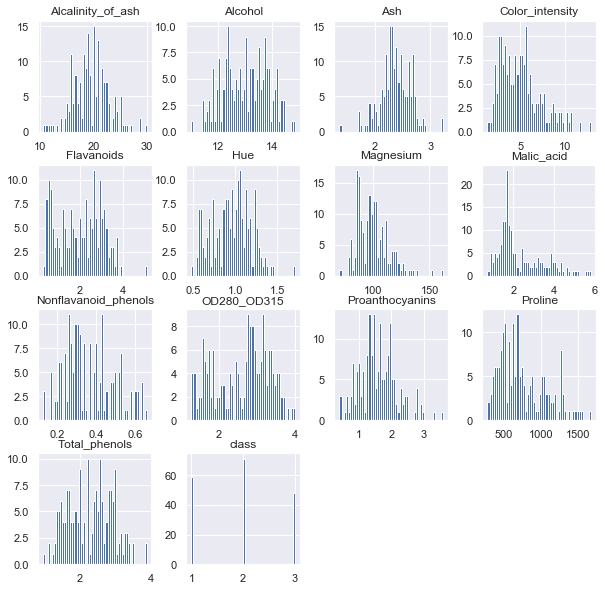

In [12]:
wine.hist(bins=50, figsize=(10, 10))

### b) 결측치 유무 확인

In [13]:
wine.isnull().sum() #null 개수 확인

class                   0
Alcohol                 0
Malic_acid              0
Ash                     0
Alcalinity_of_ash       0
Magnesium               0
Total_phenols           0
Flavanoids              0
Nonflavanoid_phenols    0
Proanthocyanins         0
Color_intensity         0
Hue                     0
OD280_OD315             0
Proline                 0
dtype: int64

In [14]:
#또는 이 방법으로 확인해도 됨
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic_acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Alcalinity_of_ash     178 non-null    float64
 5   Magnesium             178 non-null    int64  
 6   Total_phenols         178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid_phenols  178 non-null    float64
 9   Proanthocyanins       178 non-null    float64
 10  Color_intensity       178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD280_OD315           178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


** 결론: null 값 없음! **

### c) feature 결정하기

In [15]:
corr= wine[wine.columns].corr()

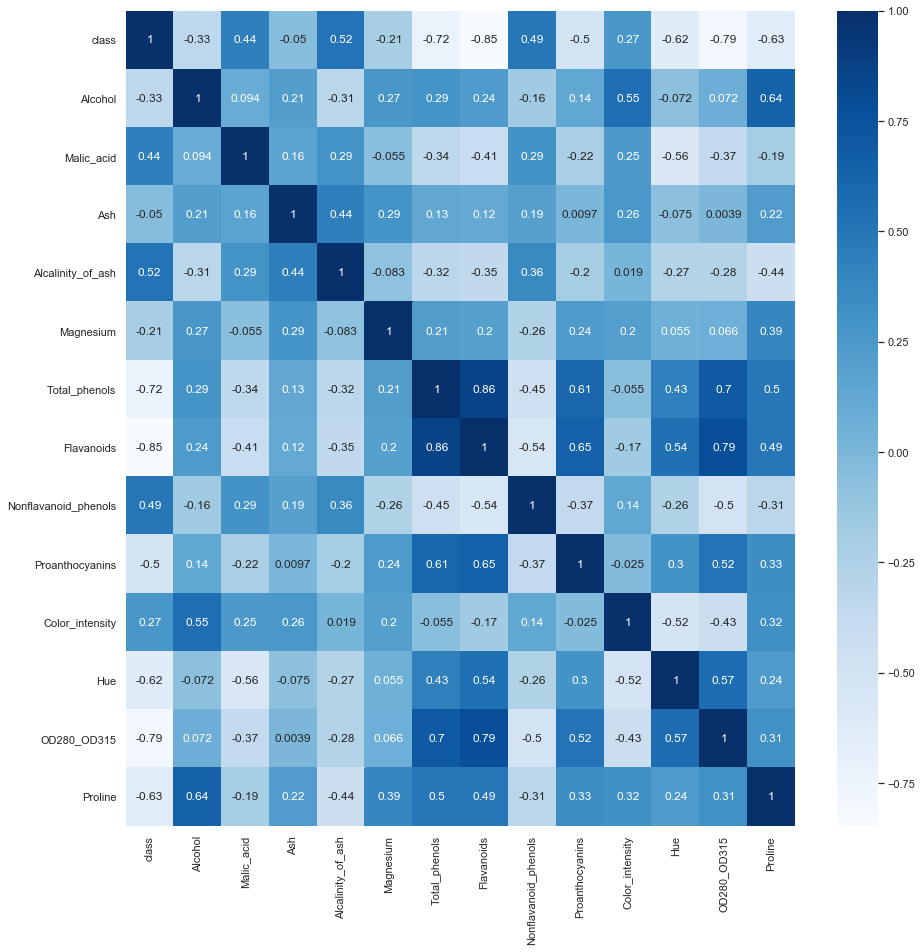

In [16]:
plt.subplots(figsize=(15,15)) #보기 힘들어서 크게 그렸어요!
sns.heatmap(corr, cmap="Blues", annot=True)

#matplotlib heatmap색상은 https://matplotlib.org/examples/color/colormaps_reference.html 참고

feature selection을 어떻게 해야할지 잘 모르겠어서 일단 class와의 correlation이 음의 값에서 가장 높은 Flavanoids와 양의 값에서  가장 높음 Alcalinity_of_ash, 두개의 설명변수 고름 

In [17]:
## Alcalinity of ash의 기술통계량 확인

wine['Alcalinity_of_ash'].describe()

count    178.000000
mean      19.494944
std        3.339564
min       10.600000
25%       17.200000
50%       19.500000
75%       21.500000
max       30.000000
Name: Alcalinity_of_ash, dtype: float64

In [18]:
## Flavanoids의 기술통계량 확인

wine['Flavanoids'].describe()

count    178.000000
mean       2.029270
std        0.998859
min        0.340000
25%        1.205000
50%        2.135000
75%        2.875000
max        5.080000
Name: Flavanoids, dtype: float64

In [19]:
ht = np.linspace(8, 35, 500) ## 기술통계량 보고 X축 설정하기

## 2. Train-Test set split하기

sklearn 사용한 방법 (이게 더 간편한 것 같지만 이걸 사용할 경우 뒤의 과정에서 자꾸 오류가 나서 노가다 방식을 썼습니다...ㅠㅠ)

In [20]:
from sklearn.model_selection import train_test_split

X= wine[['Flavanoids', 'Alcalinity_of_ash']]
Y= wine[['class']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) 

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [21]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(124, 2) (124, 1)
(54, 2) (54, 1)


또 다른 방법 사용

In [22]:
data = wine[['Flavanoids', 'Alcalinity_of_ash','class']]

N = data.shape[0]
test = np.random.choice(np.arange(N), int(N*0.3), replace=False)  #7:3으로 split
test_df = data[data.index.isin(test)].copy()
train_df = data[~data.index.isin(test)].copy()
print(train_df.shape, test_df.shape)

X_train = train_df[['Alcalinity_of_ash','Flavanoids']]
Y_train = train_df['class']
X_test = test_df[['Alcalinity_of_ash','Flavanoids']]
Y_test = test_df['class']

X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

(125, 3) (53, 3)


## 3. Test에 다음의 모델을 fit해보기

### a) LDA / GDA

In [23]:
## Rearrange Training data set for LDA fitting 
X_train_input = np.vstack((X_train['Alcalinity_of_ash'], X_train['Flavanoids'])).T  ## Transpose
Y_train_input = np.hstack((np.repeat(1, sum(Y_train==1)), np.repeat(2, sum(Y_train==2)), np.repeat(3, sum(Y_train==3))))
X_test_input = np.vstack((X_test['Alcalinity_of_ash'], X_test['Flavanoids'])).T  ## Transpose
Y_test_input = np.hstack((np.repeat(1, sum(Y_test==1)), np.repeat(2, sum(Y_test==2)), np.repeat(3, sum(Y_test==3))))

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA에 fitting 해보기

In [25]:
## Fitting on LDA

clf_LDA = LinearDiscriminantAnalysis().fit(X_train_input,Y_train_input)
w = clf_LDA.coef_; w0 = clf_LDA.intercept_
db1 = -w0[0]/w[0, 1] - w[0, 0]/w[0, 1] * ht    ## Decision boundary 1
db2 = -w0[1]/w[1, 1] - w[1, 0]/w[1, 1] * ht    ## Decision boundary 2
db3 = -w0[2]/w[2, 1] - w[2, 0]/w[2, 1] * ht    ## Decision boundary 3

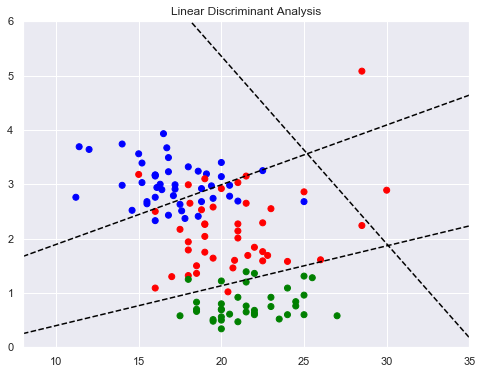

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set(xlim=(8, 35), ylim=(0, 6), title='Linear Discriminant Analysis')
colors=np.array(['blue','red', 'green'])
ax.scatter(X_train_input[:,0], X_train_input[:,1], color=colors[Y_train_input-1])
ax.plot(ht, db1.T, label='LDA DB', color='black', linestyle='--')      ## Decision boundary 1
ax.plot(ht, db2.T, label='LDA DB', color='black', linestyle='--')      ## Decision boundary 2
ax.plot(ht, db3.T, label='LDA DB', color='black', linestyle='--')      ## Decision boundary 3

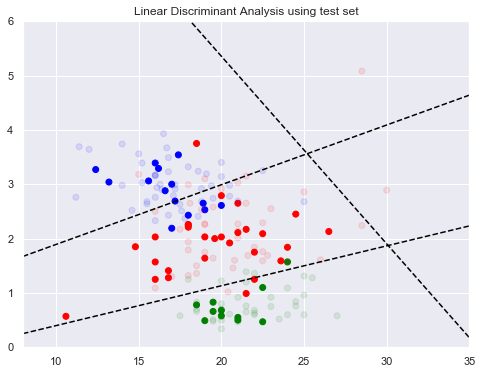

In [27]:
## Test set으로 scatter plot 그려보기

fig, ax = plt.subplots(figsize=(8,6))
ax.set(xlim=(8, 35), ylim=(0, 6), title='Linear Discriminant Analysis using test set')
colors=np.array(['blue','red', 'green'])
ax.scatter(X_test_input[:,0], X_test_input[:,1], color=colors[Y_test_input-1])
ax.scatter(X_train_input[:,0], X_train_input[:,1], color=colors[Y_train_input-1], alpha = 0.1)
ax.plot(ht, db1.T, label='LDA DB', color='black', linestyle='--')
ax.plot(ht, db2.T, label='LDA DB', color='black', linestyle='--')
ax.plot(ht, db3.T, label='LDA DB', color='black', linestyle='--')

QDA에 fitting해보기

QDA train Score:  0.864
LDA train Score:  0.856


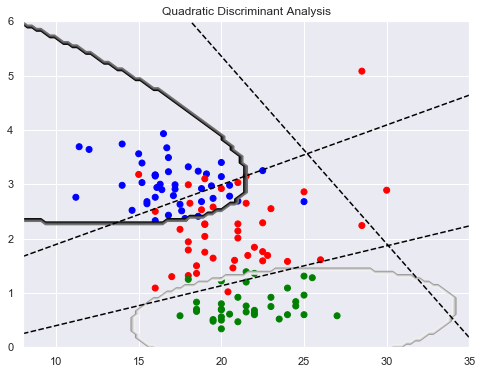

In [28]:
## Fitting on QDA

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf_QDA = QuadraticDiscriminantAnalysis().fit(X_train_input,Y_train_input)
print('QDA train Score: ', clf_QDA.score(X_train_input,Y_train_input))

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set(xlim=(8, 35), ylim=(0, 6), title='Quadratic Discriminant Analysis')
colors=np.array(['blue','red', 'green'])
ax1.scatter(X_train_input[:,0], X_train_input[:,1], color=colors[Y_train_input-1])

## Plot LDA Decision Boundary
ax1.plot(ht, db1.T, label='LDA DB', color='black', linestyle='--')
ax1.plot(ht, db2.T, label='LDA DB', color='black', linestyle='--')
ax1.plot(ht, db3.T, label='LDA DB', color='black', linestyle='--')
print('LDA train Score: ', clf_LDA.score(X_train_input,Y_train_input))

## Plot QDA Decision Boundary
r1 = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
r2 = np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100)
R1, R2 = np.meshgrid(r1, r2)
R = np.c_[R1.ravel(), R2.ravel()]
Z = clf_QDA.predict(R).reshape(R1.shape)
ax1.contour(R1, R2, Z, cmap="Greys_r")

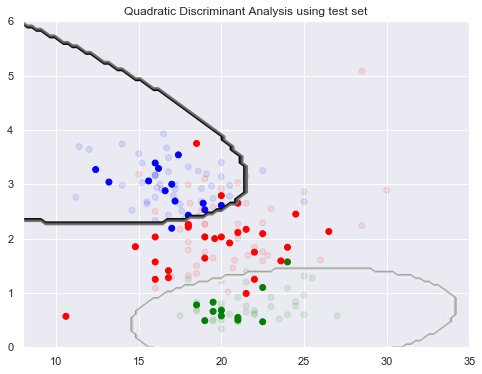

In [29]:
## Test set으로 scatter plot 그려보기

fig, ax = plt.subplots(figsize=(8,6))
ax.set(xlim=(8, 35), ylim=(0, 6), title='Quadratic Discriminant Analysis using test set')
colors=np.array(['blue','red', 'green'])
ax.scatter(X_test_input[:,0], X_test_input[:,1], color=colors[Y_test_input-1])
ax.scatter(X_train_input[:,0], X_train_input[:,1], color=colors[Y_train_input-1], alpha = 0.1)
ax.contour(R1, R2, Z, cmap="Greys_r")

### b) Logistic Regression 

In [30]:
## Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_log1 = LogisticRegression(solver='lbfgs',   #‘lbfgs’ handles multinomial loss
                         max_iter=1000).fit(X_train_input, Y_train_input)
clf_log1.predict(X_train_input[:100,:]) # return class
clf_log1.predict_proba(X_train_input[:100,:]) # return probability
print(clf_log1.score(X_train_input, Y_train_input)) # return 1- Error rate in Training set

0.872


### c) Logistic Regression with feature expansion

K-cv로 차수 결정하기

In [31]:
## Logistic Regression with Feature Extraction: Poly
## kcv로 차수결정

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
kcv = KFold(n_splits=5, shuffle=True)

kcvMSE_train = np.zeros(0)     # MSE 저장용 array 생성
kcvMSE_test = np.zeros(0)


for i in np.arange(10):
    for train_index, test_index in kcv.split(X_train_input, Y_train_input):
        print("TRAIN:", train_index, "TEST:", test_index)
        CV_X_train, CV_X_test = X_train_input[train_index,:], X_train_input[test_index,:]
        CV_Y_train, CV_Y_test = Y_train_input[train_index], Y_train_input[test_index]
    
        poly = PolynomialFeatures(degree=i+1, include_bias=False)
        X_poly = poly.fit_transform(CV_X_train)   # order : [X1 X2 X1^2 X1*X2 X2^2]
        clf_log2 = LogisticRegression(max_iter=10000).fit(CV_X_train, CV_Y_train)
        kcvMSE_train = np.append(kcvMSE_train, sum(clf_log2.predict(CV_X_train)!=CV_Y_train)/len(CV_Y_train))
        kcvMSE_test = np.append(kcvMSE_test, sum(clf_log2.predict(CV_X_test)!=CV_Y_test)/len(CV_Y_test))

TRAIN: [  0   1   2   3   4   6   8   9  10  11  12  13  15  16  20  21  22  23
  24  25  26  27  28  29  31  34  35  36  37  38  39  40  41  43  44  45
  46  47  48  49  50  52  54  55  56  57  58  59  60  61  62  64  65  66
  67  68  69  70  71  72  74  75  76  77  78  79  80  81  82  84  85  87
  89  90  91  92  93  95  97  98  99 100 102 103 104 106 107 108 109 110
 112 113 114 116 117 118 119 120 123 124] TEST: [  5   7  14  17  18  19  30  32  33  42  51  53  63  73  83  86  88  94
  96 101 105 111 115 121 122]
TRAIN: [  0   3   4   5   6   7   8   9  11  14  15  17  18  19  20  21  22  27
  28  29  30  32  33  34  35  36  38  39  40  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  57  58  59  60  61  62  63  65  66  67  68
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  85  86  88  90
  91  94  95  96  98  99 100 101 102 103 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 122 124] TEST: [  1   2  10  12  13  16  23  24  25  26  31  37  41  56 

In [32]:
kcvMSE_train = kcvMSE_train.reshape(10, 5)
kcvMSE_test = kcvMSE_test.reshape(10, 5)

In [33]:
## 평균으로 MSE값 계산하기
kcvMSE_train_mean = np.zeros((10, 1))
kcvMSE_test_mean = np.zeros((10, 1))

for i in np.arange(10):
    kcvMSE_train_mean[i] = np.mean(kcvMSE_train[i, :])
    kcvMSE_test_mean[i] = np.mean(kcvMSE_test[i, :])

print(kcvMSE_train_mean)
print(kcvMSE_test_mean)

[[0.138]
 [0.14 ]
 [0.128]
 [0.134]
 [0.14 ]
 [0.142]
 [0.132]
 [0.136]
 [0.14 ]
 [0.134]]
[[0.176]
 [0.144]
 [0.16 ]
 [0.16 ]
 [0.136]
 [0.184]
 [0.168]
 [0.152]
 [0.208]
 [0.144]]


In [34]:
## Logistic Regression with Feature Expansion: Polynomial with degree 2

poly = PolynomialFeatures(degree=3, include_bias=False) # No column of 1s
X_poly_train = poly.fit_transform(X_train_input)   # order : [X1 X2 X1^2 X1*X2 X2^2]
X_poly_test = poly.fit_transform(X_test_input)
clf_log2 = LogisticRegression(max_iter=10000).fit(X_poly_train, Y_train_input)
print(clf_log2.score(X_poly_train, Y_train_input)) # return 1- Error rate in Training set

0.872


## 4. 각 모델에 대해 Test MSE 보고하고 결과 해석하기

In [35]:
from sklearn.metrics import mean_squared_error as mse

In [36]:
## LDA의 MSE 계산하기
print(mse(Y_test_input,clf_LDA.predict(X_test_input)))

0.16981132075471697


In [37]:
## QDA의 MSE 계산하기
print(mse(Y_test_input,clf_QDA.predict(X_test_input)))

0.11320754716981132


In [38]:
## Logistic Regreesion의 Test MSE 구하기
print(mse(Y_test_input, clf_log1.predict(X_test_input)))

0.16981132075471697


In [39]:
## Test MSE 계산하기
print(mse(Y_test_input, clf_log2.predict(X_poly_test)))

0.16981132075471697


MSE가 가장 작은 QDA가 가장 좋음